# Preparing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

In [2]:
# Ignoring warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [3]:
# Uploading data
data = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv', index_col = [0],  parse_dates = [0])

data_new = pd.read_csv('/kaggle/input/london-weather-data/london_weather.csv', index_col = [0],  parse_dates = [0])
# Sorting indexes
data.sort_index(ascending = True)
# Checking whether indexes monotonic or not
print(data.index.is_monotonic_increasing)

True


In [4]:
#data.head()

data_new.head()

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
date,,,,,,,,,
1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [5]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15341 entries, 1979-01-01 to 2020-12-31
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       15322 non-null  float64
 1   sunshine          15341 non-null  float64
 2   global_radiation  15322 non-null  float64
 3   max_temp          15335 non-null  float64
 4   mean_temp         15305 non-null  float64
 5   min_temp          15339 non-null  float64
 6   precipitation     15335 non-null  float64
 7   pressure          15337 non-null  float64
 8   snow_depth        13900 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [6]:
data_new = data_new.drop(['min_temp', 'max_temp'], axis = 1)

In [7]:
data_new.isna().sum()

cloud_cover           19
sunshine               0
global_radiation      19
mean_temp             36
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [8]:
data_new = data_new.dropna()

In [9]:
#data = data.rename(columns={'meantemp': 'temperature'})
data_new = data_new.rename(columns={'mean_temp': 'temperature'})

In [10]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13843 entries, 1979-01-01 to 2019-12-31
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       13843 non-null  float64
 1   sunshine          13843 non-null  float64
 2   global_radiation  13843 non-null  float64
 3   temperature       13843 non-null  float64
 4   precipitation     13843 non-null  float64
 5   pressure          13843 non-null  float64
 6   snow_depth        13843 non-null  float64
dtypes: float64(7)
memory usage: 865.2 KB


In [11]:
data_new.isna().sum()

cloud_cover         0
sunshine            0
global_radiation    0
temperature         0
precipitation       0
pressure            0
snow_depth          0
dtype: int64

In [12]:
data_new.describe()

,cloud_cover,sunshine,global_radiation,temperature,precipitation,pressure,snow_depth
count,13843.00000,13843.000000,13843.000000,13843.000000,13843.000000,13843.000000,13843.000000
mean,5.32818,4.262609,114.529148,11.085408,1.667493,101538.493101,0.037853
std,2.03417,3.987488,87.758136,5.700936,3.733947,1066.084413,0.545712
min,0.00000,0.000000,12.000000,-7.600000,0.000000,95960.000000,0.000000
25%,4.00000,0.400000,39.000000,6.800000,0.000000,100900.000000,0.000000
50%,6.00000,3.400000,89.000000,10.800000,0.000000,101630.000000,0.000000
75%,7.00000,7.100000,180.000000,15.550000,1.600000,102260.000000,0.000000
max,9.00000,15.700000,352.000000,29.000000,61.800000,104430.000000,22.000000


# EDA

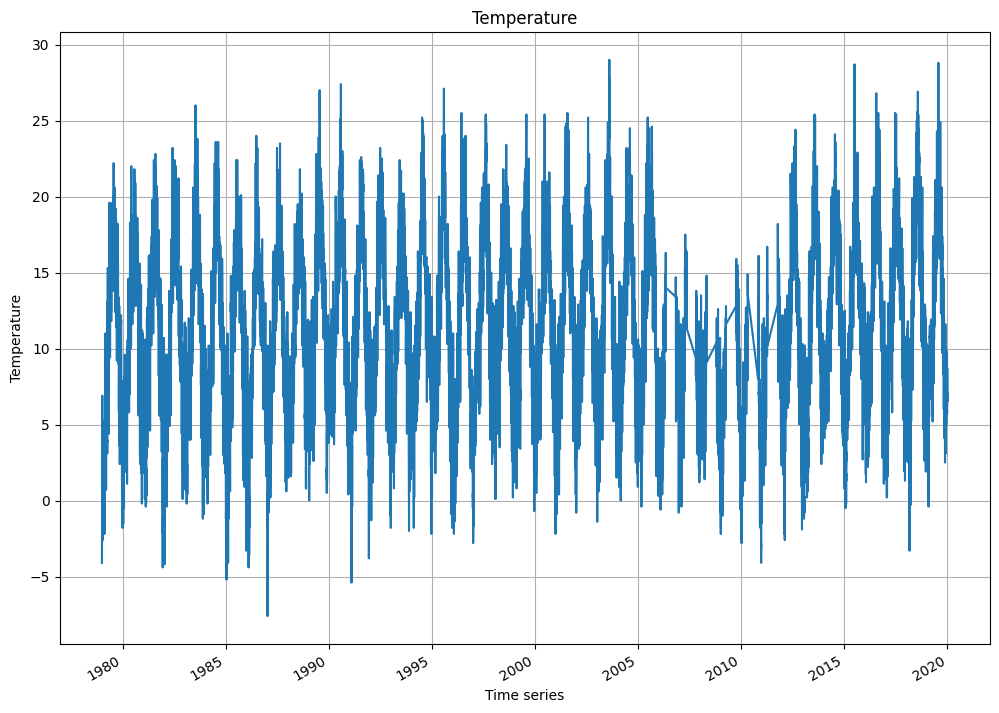

In [13]:
data_new['temperature'].plot(figsize = (12, 9), title = 'Temperature')
plt.grid()
plt.xlabel('Time series')
plt.ylabel('Temperature');

In [14]:
data_final = data_new['1979-01-01':'2005-01-01']

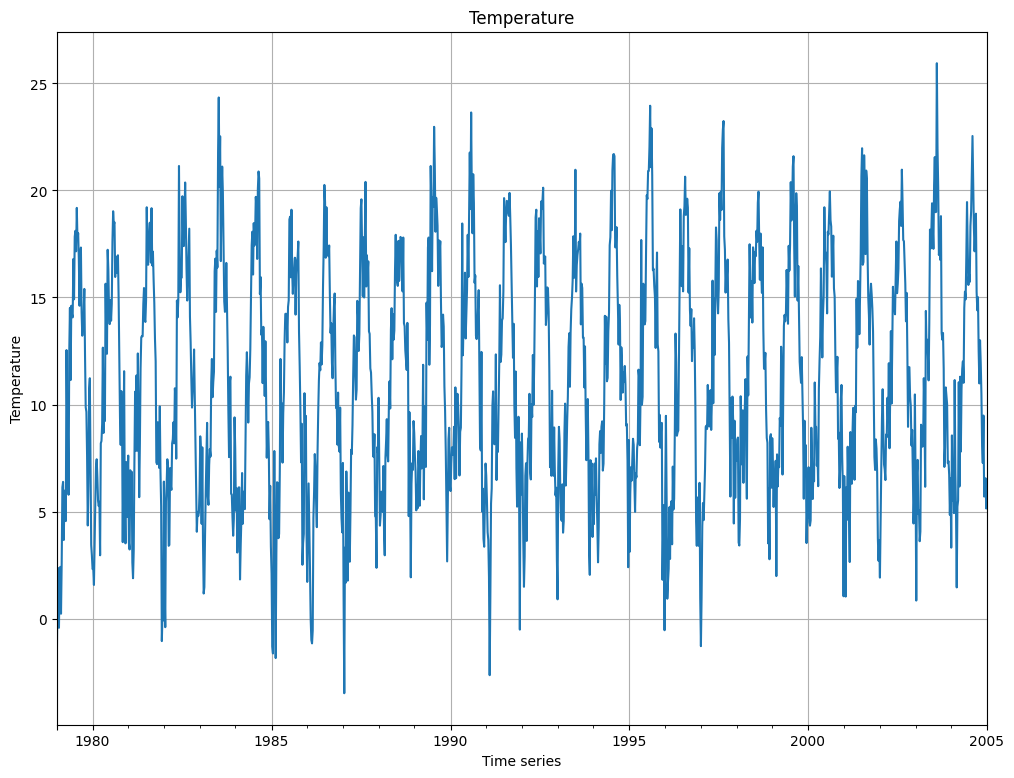

In [15]:
# Resampling dataframe by 1 week
# data = data.resample('1W').mean()
# data['temperature'].plot(figsize = (12, 9), title = 'temperature')
# plt.xlabel('Time series')
# plt.ylabel('Temperature');

data_final = data_final.resample('w').mean()
data_final['temperature'].plot(figsize = (12, 9), title = 'Temperature')
plt.grid()
plt.xlabel('Time series')
plt.ylabel('Temperature');

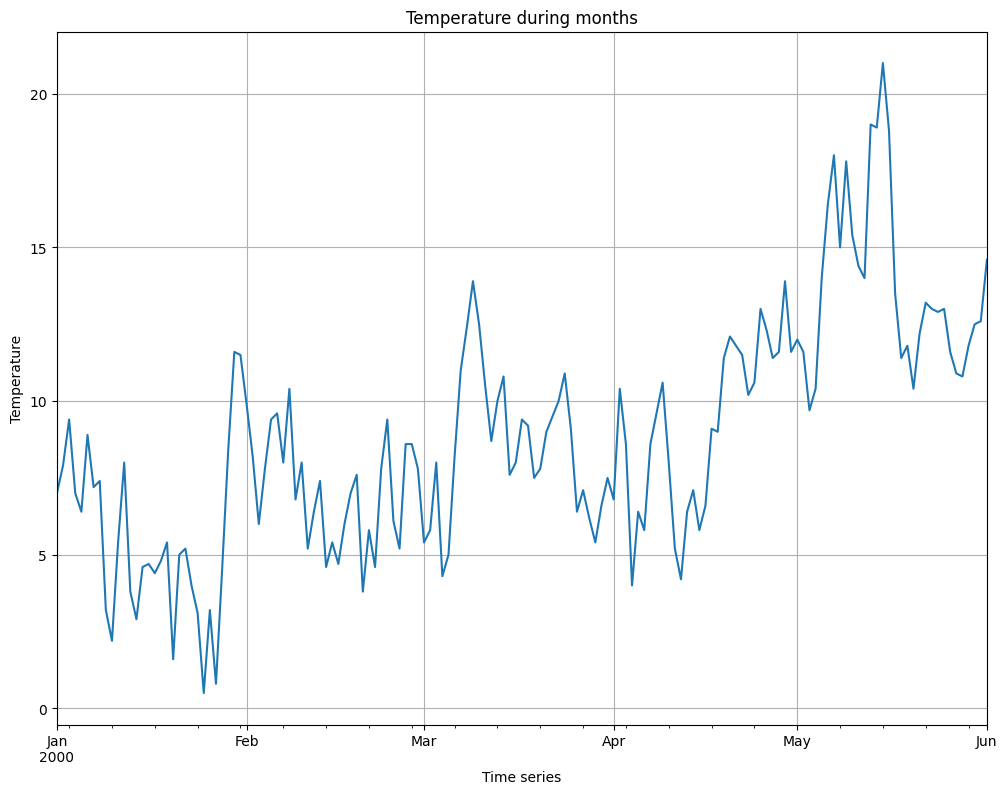

In [16]:
data_month = data_new['2000-01-01' : '2000-06-01']
data_month['temperature'].plot(figsize = (12, 9), title = 'Temperature during months')
plt.grid()
plt.xlabel('Time series')
plt.ylabel('Temperature');

In [17]:
data_final['temperature'].isna().sum()

0

In [18]:
data_final.shape

(1357, 7)

In [19]:
decomposed_data = seasonal_decompose(data_final['temperature'])

In [20]:
# Building three plots to visualize the trend, seasonality, and residuals of temperature

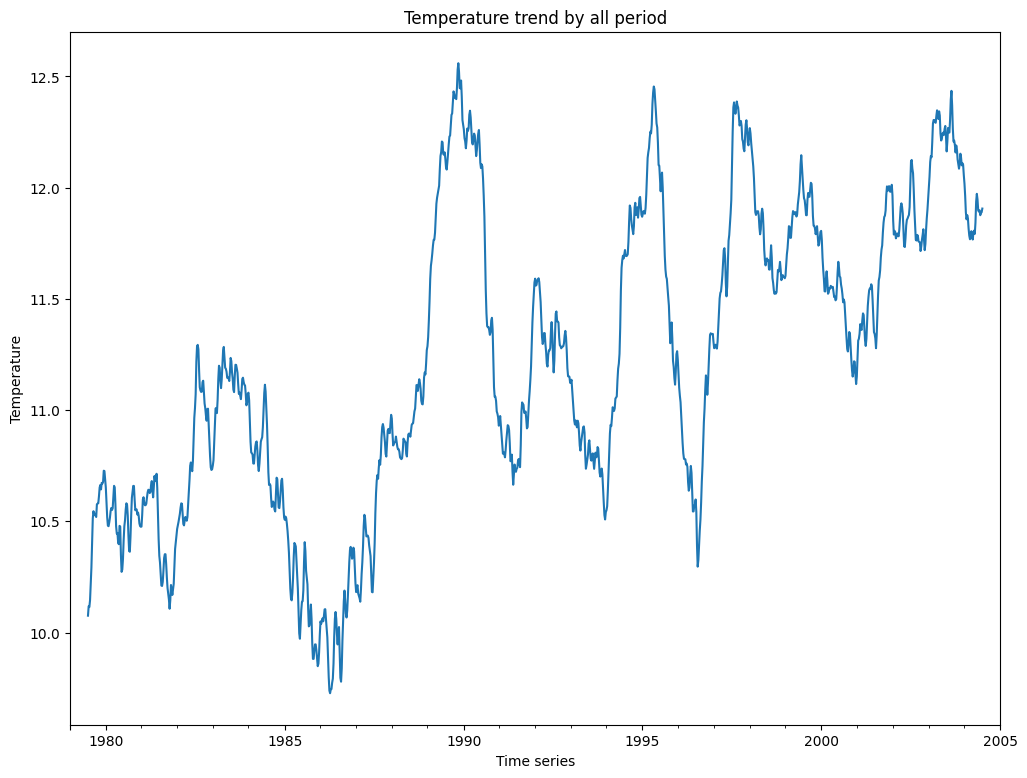

In [21]:
decomposed_data.trend.plot(figsize = (12, 9), title = 'Temperature trend by all period')
plt.ylabel('Temperature')
plt.xlabel('Time series');

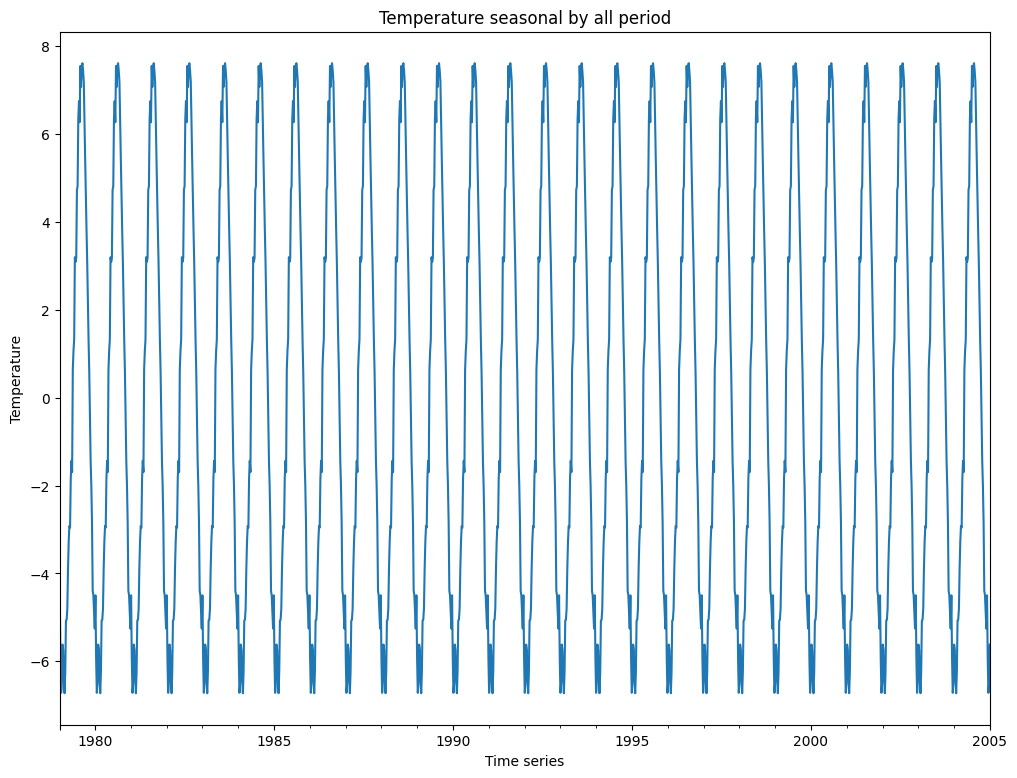

In [22]:
decomposed_data.seasonal.plot(figsize = (12, 9), title = 'Temperature seasonal by all period')
plt.ylabel('Temperature')
plt.xlabel('Time series');

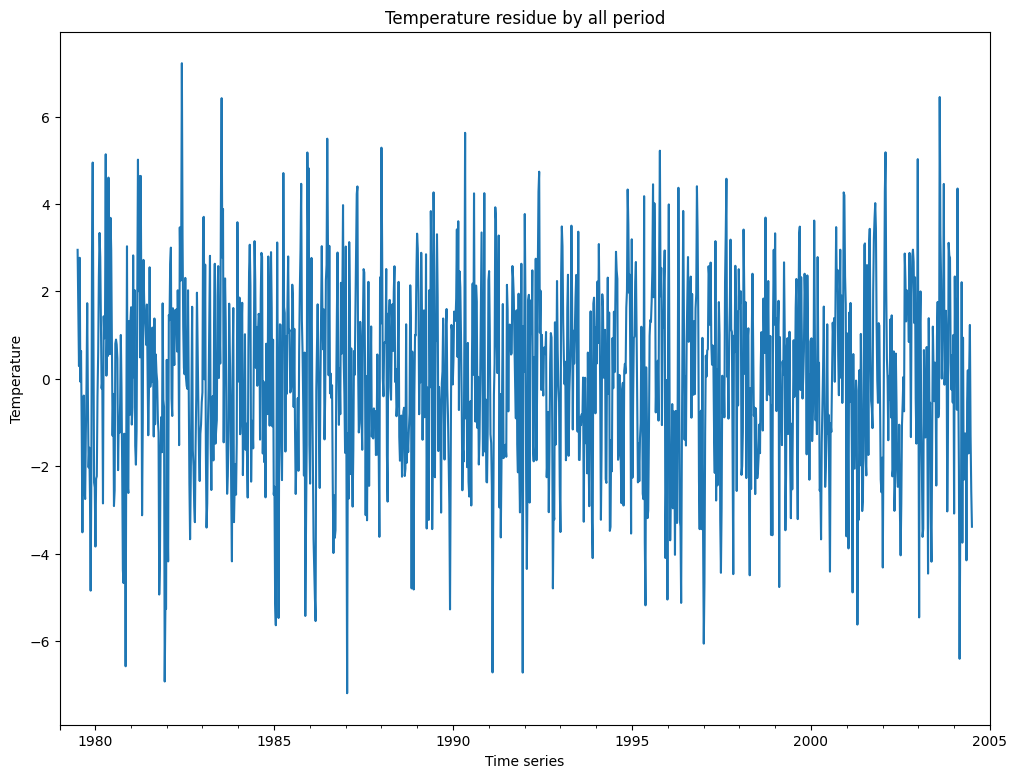

In [23]:
decomposed_data.resid.plot(figsize = (12, 9), title = 'Temperature residue by all period')
plt.ylabel('Temperature')
plt.xlabel('Time series');

In [24]:
# Preparing dataset for building a plot of rolling standard deviation
data_shift = data_final - data_final.shift()
data_shift['mean'] = data_shift['temperature'].rolling(7).mean()
data_shift['std'] = data_shift['temperature'].rolling(7).std()

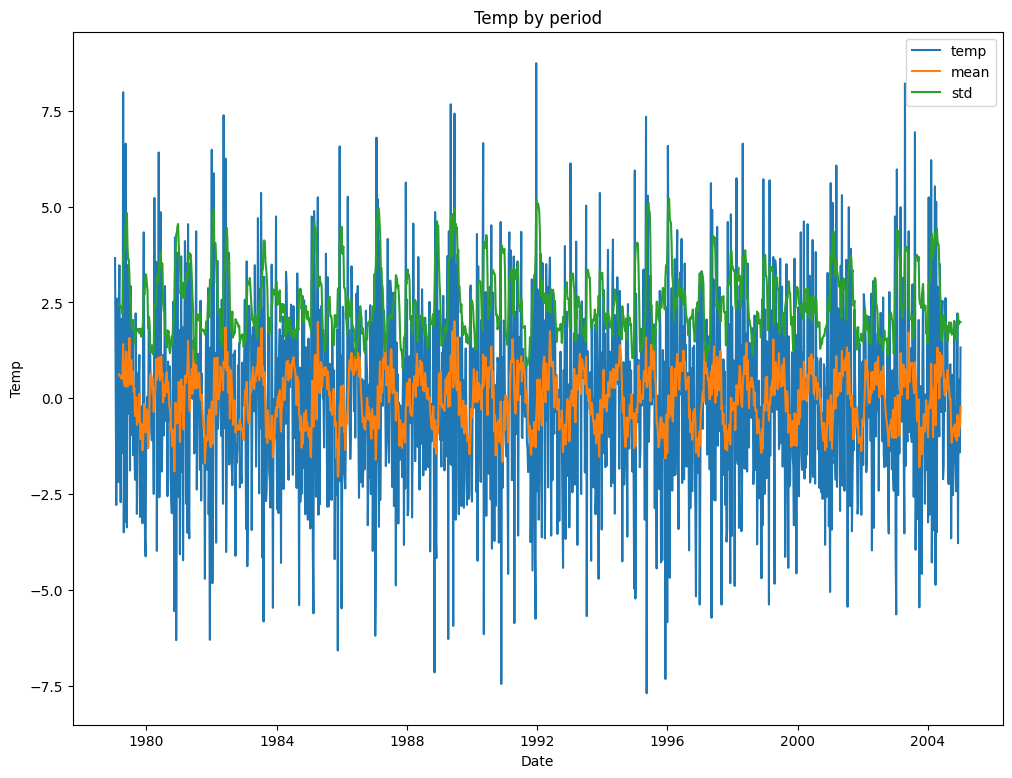

In [25]:
fig, ax = plt.subplots(figsize = (12, 9))
ax.plot(data_shift['temperature'])
ax.plot(data_shift['mean'])
ax.plot(data_shift['std'])
ax.legend(['temp', 'mean', 'std'])
ax.set_xlabel('Date')
ax.set_ylabel('Temp')
ax.set_title("Temp by period");

In [26]:
max_lag = 7
rolling_mean_size = 7

def make_features(data_final, max_lag, rolling_mean_size):
    data_final['year'] = data_final.index.year
    data_final['month'] = data_final.index.month
    data_final['day'] = data_final.index.day
    data_final['dayofweek'] = data_final.index.dayofweek
    for lag in range(1, max_lag + 1):
        data_final['lag_{}'.format(lag)] = data_final['temperature'].shift(lag)

    data_final['rolling_mean'] = data_final['temperature'].shift().rolling(rolling_mean_size).mean()

In [27]:
data_ready = data_final.copy()

In [28]:
print(data_ready)

            cloud_cover  sunshine  global_radiation  temperature  \
date                                                               
1979-01-07     5.714286  2.071429         26.571429    -1.700000   
1979-01-14     4.428571  4.000000         39.285714     1.957143   
1979-01-21     7.800000  0.000000         15.400000     2.360000   
1979-01-28     6.000000  1.800000         33.142857    -0.428571   
1979-02-04     5.142857  1.942857         37.571429     2.171429   
...                 ...       ...               ...          ...   
2004-12-05     5.857143  1.114286         22.285714     5.700000   
2004-12-12     5.857143  1.228571         21.142857     6.071429   
2004-12-19     6.000000  1.314286         21.142857     6.557143   
2004-12-26     5.285714  1.728571         24.285714     5.142857   
2005-01-02     4.833333  2.716667         30.500000     6.466667   

            precipitation       pressure  snow_depth  
date                                                  
1979-

In [29]:
make_features(data_ready, max_lag, rolling_mean_size)

train, remain = train_test_split(data_ready, shuffle = False, test_size = 0.2)
valid, test = train_test_split(remain, shuffle = False, test_size = 0.5)
train = train.dropna()

features_train = train.drop(['temperature'], axis = 1)
target_train = train['temperature']

features_valid = valid.drop(['temperature'], axis = 1)
target_valid = valid['temperature']

features_test = test.drop(['temperature'], axis = 1)
target_test = test['temperature']

# Models

## LightGBM

In [30]:
model_LGBM = LGBMRegressor(n_estimators = 100)
tscv = TimeSeriesSplit(n_splits=5).split(features_train)

params_lgbm = {
    'max_depth' : [2, 4, 6],
    'n_estimators' : [100, 250],
    'verbose': [-1]
}


model_LGBM_GS = GridSearchCV(
    estimator = model_LGBM,
    param_grid = params_lgbm,
    scoring = 'neg_root_mean_squared_error',
    cv = tscv
)

model_LGBM_GS.fit(features_train, target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x79ee84686260>,
             estimator=LGBMRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'n_estimators': [100, 250],
                         'verbose': [-1]},
             scoring='neg_root_mean_squared_error')

In [31]:
%%time
lgbm_best_params = model_LGBM_GS.best_params_
predict_LGBM = model_LGBM_GS.predict(features_valid)
lgbm_score = model_LGBM_GS.best_score_ * -1
print(lgbm_best_params)
print(lgbm_score)

{'max_depth': 4, 'n_estimators': 100, 'verbose': -1}
2.041516675081242
CPU times: user 4.17 ms, sys: 727 µs, total: 4.89 ms
Wall time: 5.58 ms


## CatBoost

In [32]:
%%time

tscv = TimeSeriesSplit(n_splits=5).split(features_train)
CB_model = CatBoostRegressor()

cat_params = {
    'depth' : [2, 4, 6],
    'n_estimators' : [100, 250]
               }

cat_GS = GridSearchCV(CB_model, 
                       cat_params, 
                       scoring = 'neg_root_mean_squared_error', 
                       cv = tscv)

cat_GS.fit(features_train, target_train, verbose=100)

Learning rate set to 0.203539
0:	learn: 4.6510196	total: 54.5ms	remaining: 5.39s
99:	learn: 1.1133475	total: 73.7ms	remaining: 0us
Learning rate set to 0.226702
0:	learn: 4.6883474	total: 535us	remaining: 53ms
99:	learn: 1.3469740	total: 26.4ms	remaining: 0us
Learning rate set to 0.24156
0:	learn: 4.5735686	total: 497us	remaining: 49.2ms
99:	learn: 1.4576018	total: 34.4ms	remaining: 0us
Learning rate set to 0.252719
0:	learn: 4.5480867	total: 494us	remaining: 48.9ms
99:	learn: 1.5325595	total: 33.8ms	remaining: 0us
Learning rate set to 0.261742
0:	learn: 4.5259523	total: 540us	remaining: 53.5ms
99:	learn: 1.5497231	total: 37.5ms	remaining: 0us
Learning rate set to 0.096632
0:	learn: 4.9878616	total: 533us	remaining: 133ms
100:	learn: 1.4499518	total: 20.6ms	remaining: 30.3ms
200:	learn: 1.1572764	total: 40.9ms	remaining: 9.96ms
249:	learn: 1.0434011	total: 50.9ms	remaining: 0us
Learning rate set to 0.107629
0:	learn: 5.0734089	total: 522us	remaining: 130ms
100:	learn: 1.5635520	total: 

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x79ee84686730>,
             estimator=<catboost.core.CatBoostRegressor object at 0x79ee84597190>,
             param_grid={'depth': [2, 4, 6], 'n_estimators': [100, 250]},
             scoring='neg_root_mean_squared_error')

In [33]:
%%time
cat_best_params = cat_GS.best_params_
predict_cat = cat_GS.predict(features_valid)
cat_score = cat_GS.best_score_ * -1
print(cat_best_params)
print(cat_score)

{'depth': 4, 'n_estimators': 250}
1.9741543738601117
CPU times: user 3.91 ms, sys: 0 ns, total: 3.91 ms
Wall time: 2.69 ms


## XGBoost

In [34]:
%%time

tscv = TimeSeriesSplit(n_splits=5).split(features_train)

XGB_model = xgb.XGBRegressor()

XGB_params = {
    'max_depth' : [2, 4, 6],
    'n_estimators' : [100, 250]
            }

XGB_GS = GridSearchCV(XGB_model, 
                       XGB_params, 
                       scoring = 'neg_root_mean_squared_error', 
                       cv = tscv)

XGB_GS.fit(features_train, target_train, verbose=1)

CPU times: user 4.74 s, sys: 72.3 ms, total: 4.81 s
Wall time: 4.85 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x79ee846852a0>,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=N...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [2, 4, 6], 'n_estimators': [100, 250]},
             scoring='neg_root_mean_squared_error')

In [35]:
%%time
XGB_best_params = XGB_GS.best_params_
predict_XGB = XGB_GS.predict(features_valid)
XGB_score = XGB_GS.best_score_ * -1
print(XGB_best_params)
print(XGB_score)

{'max_depth': 4, 'n_estimators': 100}
2.082044921244859
CPU times: user 4.66 ms, sys: 1.25 ms, total: 5.91 ms
Wall time: 4.61 ms


# Testing the best model

In [36]:
def rmse(test, predict):
    return ((mean_squared_error(test, predict)) ** 0.5).round(2)

In [37]:
%%time
predict_XGB_test = XGB_GS.predict(features_test)
rmse_XGB_test = rmse(target_test, predict_XGB_test)

print(rmse_XGB_test)

1.82
CPU times: user 5.56 ms, sys: 1.09 ms, total: 6.65 ms
Wall time: 5.97 ms


In [38]:
def graphicaizer(predictions):
    model_data = pd.DataFrame({"target":target_test, "predict":predictions})
    model_data.plot(figsize=(18, 6))
    plt.xlabel('Time series')
    plt.ylabel('Temperature')

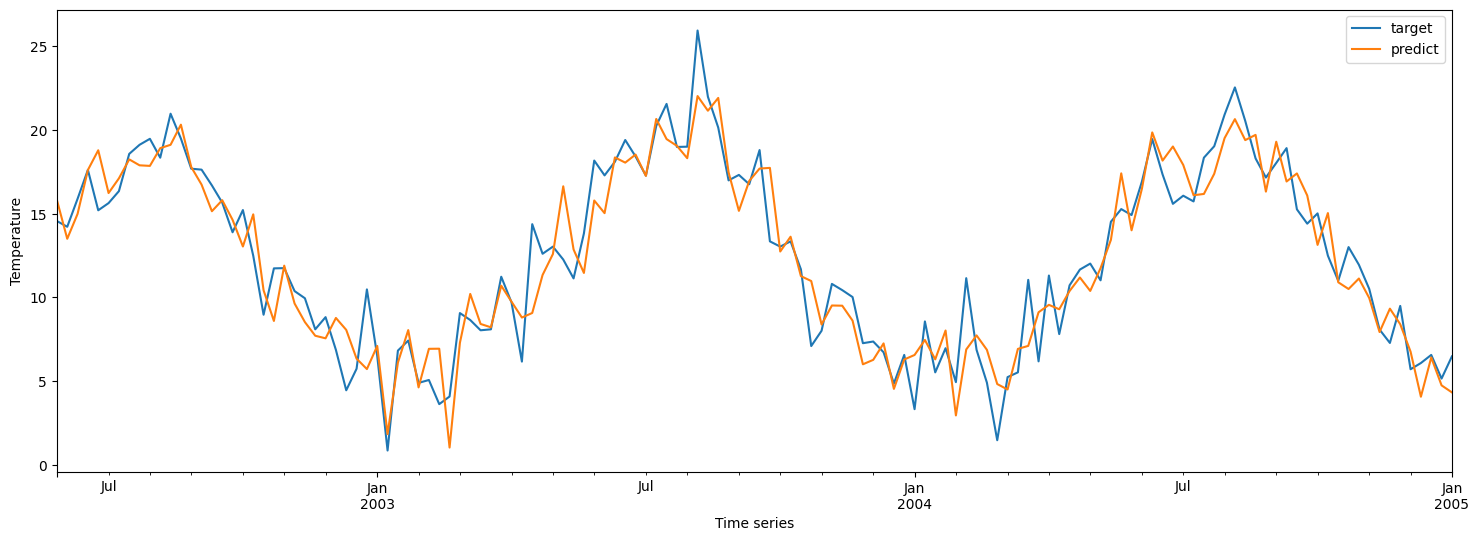

In [39]:
graphicaizer(predict_XGB_test)